In [12]:
import abtem
import matplotlib.pyplot as plt
import numpy as np
from ase import Atoms
from ase.visualize import view
from ase.io import read

# Atomic models with ASE
abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model atomic structures. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as GPAW for running DFT simulations. Here, we introduce the set of features of ASE needed for image simulations; please refer to the ASE documentation for a more general introduction.

## Atoms
The Atoms object defines a collection of atoms. Here is how to set up an $\mathrm{N}_2$ molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom):

In [13]:
n2 = Atoms('2N', positions=[(0., 0., 0.), (0., 0., 1.10)], cell=[2, 2, 2])

A basic abTEM simulation only uses the positional coordinates, atomic numbers and the unit cell for creating electrostatic potentials. 

We access the $xyz$ positions as an $n\times 3$ array, where $n$ is the number of atoms, and the correspondiong atomic numbers below:

In [102]:
n2.positions, n2.numbers

(array([[0. , 0. , 0. ],
        [0. , 0. , 1.1]]),
 array([7, 7]))

The cell can be accessed as below:

In [16]:
n2.cell

Cell([2.0, 2.0, 2.0])

```{note}
The multislice algorithm, as implemented in abtem, requires an orthogonal and periodic unit cell. It is not always trivial to create such a cell, see section below for a short introduction to the problem.
```

## Import/export

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>). 

We downloaded the structure file from the [materials project](https://materialsproject.org/). This is an open source library containing a huge number of crystal structures, calculated using density functional theory.

In [107]:
srtio3 = read('data/SrTiO3_mp-4651_conventional_standard.cif')

In [108]:
srtio3

Atoms(symbols='Sr4Ti4O12', pbc=True, cell=[5.567728, 5.567728, 7.907106], spacegroup_kinds=...)

In [109]:
write('data/srtio3_100.cif', srtio3)

## Visualize
The simplest way to visualize the atoms is the `view` function, which should bring up an interactive 3d viewer:

In [111]:
# may not work in remote environments (e.g. binder)
view(srtio3) 

<Popen: returncode: None args: ['C:\\Users\\jacob\\anaconda3\\envs\\dask-gpu...>

If you are working in a remote environment or prefer to embed the viewer in the notebook, you can install [nglview](https://github.com/nglviewer/nglview). This will allow you to use the `nglview` backend for the `view` function.

In [19]:
# may not work without installing additional dependencies
# view(srtio3, viewer='nglview') 

abTEM provides a simple viewer for embedding a basic visualization in a notebook. This function shows a 2D projection of the structure perpendicular to the specified plane. For example:

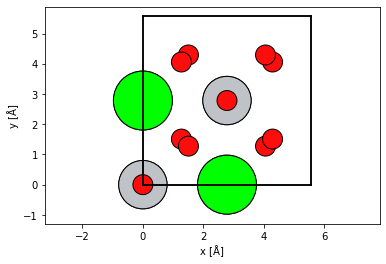

In [110]:
abtem.show_atoms(srtio3, plane='xy');

## Procedural creation
ASE also includes modules for procedurally generating special structures such as [carbon nanotubes](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes) and [nanoparticles](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html). Here we create a chirality $(6,0)$ nanotube (`length=1` here indicates the minimal commensurate unit cell along the tube axis).

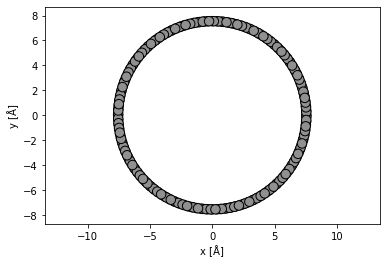

In [90]:
from ase.build import nanotube

cnt = nanotube(14, 8, length=1)

abtem.show_atoms(cnt);

As shown above, the electron propagation axis is along the length of the nanotube ($z$), which is probably not what you would like for an image simulation. To rotate the nanotube we use the ASE [rotate](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) method with the angle given in degrees and the rotation axis chosen to be $x$. Note that we also want to rotate the unit cell along with the structure.

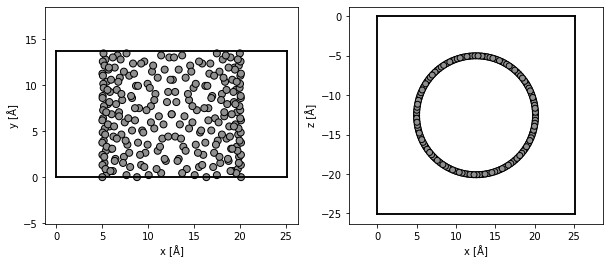

In [97]:
rotated_cnt = cnt.copy()

rotated_cnt.rotate(-90, 'x', rotate_cell=True)

rotated_cnt.center(vacuum=5, axis=(0, 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(rotated_cnt, ax=ax1);
abtem.show_atoms(rotated_cnt, ax=ax2, plane='xz');

In [98]:
rotated_cnt.cell

Cell([[25.099778234172625, 0.0, 0.0], [0.0, 1.5369181536893954e-15, -25.099778234172625], [0.0, 13.693984080609994, 8.38514688594692e-16]])

In [99]:
rotated_cnt = abtem.structures.standardize_cell(rotated_cnt)

rotated_cnt.cell

Cell([25.099778234172625, 13.693984080609994, 25.099778234172625])

## Manipulation

abTEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from negative to positive coordinate values. Hence, to choose the imaging zone axis, we need to manipulate the atoms so they are properly aligned.

ASE has a range of tools for manipulating imported structures, for example, the `surface` function, which is used for creating a periodic surface (aligned with the $z$-axis) with a given set of Miller indices.

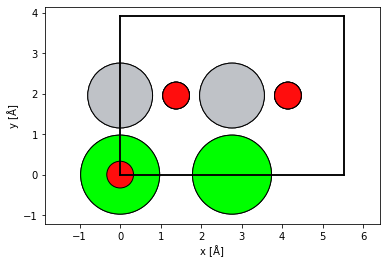

In [21]:
from ase.build import surface

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)

abtem.show_atoms(srtio3_110, plane='xy');

Simulations may require a larger crystal, to repeat the atoms by two in the $x$- and by three in the $y$-direction (but not in the $z$-direction) we can write:

In [22]:
repeated_srtio3 = srtio3_110 * (2, 3, 2)



The positions and atomic numbers are just `numpy` arrays and hence can be modified in-place. Here, we randomly substitutionally dope the structures by making the titanium atoms into indium atoms with a probability of 10 %.  

In [23]:
doped_srtio3 = repeated_srtio3.copy()

mask = doped_srtio3.numbers == 22

mask = mask * (np.random.rand(len(doped_srtio3)) < .1)

doped_srtio3.numbers[mask] = 57

Next, we center the atoms in the cell and add 3 Å of vacuum at the entrance and exit surfaces along the $z$-axis. Note that we visualize the structure now from the side, both along the $y$ and $x$ axes.

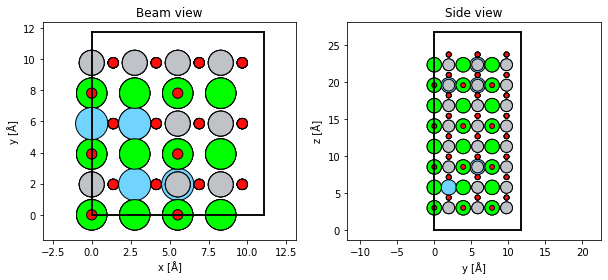

In [45]:
doped_srtio3.center(axis=2, vacuum=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(doped_srtio3, plane='xy', ax=ax1, title='Beam view')
abtem.show_atoms(doped_srtio3, plane='yz', ax=ax2, title='Side view');

The manipulated structure can also be exported to disk.

In [25]:
from ase.io import write

write('data/srtio3_110.cif', srtio3_110)

## Combining structures

<AxesSubplot:xlabel='x [Å]', ylabel='z [Å]'>

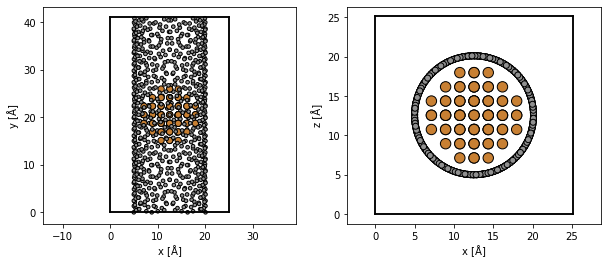

In [93]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 4, 2]
lc = 3.61000
nanoparticle = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)

repeated_cnt = rotated_cnt * (1, 3, 1)

nanoparticle.cell = repeated_cnt.cell
nanoparticle.center()

nanoparticle_in_cnt = repeated_cnt + nanoparticle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(nanoparticle_in_cnt, ax=ax1)
abtem.show_atoms(nanoparticle_in_cnt, ax=ax2, plane='xz')

In [89]:
view(nanoparticle_in_cnt)

<Popen: returncode: None args: ['C:\\Users\\jacob\\anaconda3\\envs\\dask-gpu...>

## Orthogonal and periodic supercells

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial. abTEM has a tool for solving this problem. To demonstrate the tool, we create a graphene structure with the minimal hexagonal unit cell. 

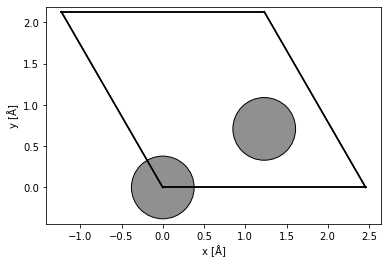

In [28]:
from ase import build

graphene = build.graphene(vacuum=2)

abtem.show_atoms(graphene);

The minimal unit cell of graphene is hexagonal, whereas the multislice algorithm requires an orthogonal unit cell. To make the unit cell orthogonal, we can use the abTEM `orthogonalize_cell` function. It is not always possible to make a periodic cell orthogonal without introducing some strain, hence we can return the strain tensor.

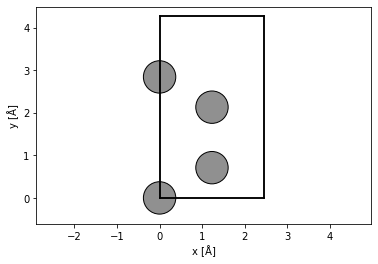

In [100]:
from abtem.structures import orthogonalize_cell, pretty_print_transform

orthogonal_graphene, transform = orthogonalize_cell(graphene, return_transform=True)

abtem.show_atoms(orthogonal_graphene);

Hexagonal cells can be made orthogonal by doubling its size without introducing any strain.

In [30]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


A common, less trivial example, is the creation of models with a specific rotation relative to the beam. Here, we want to view FCC gold at a 10 degree angle.

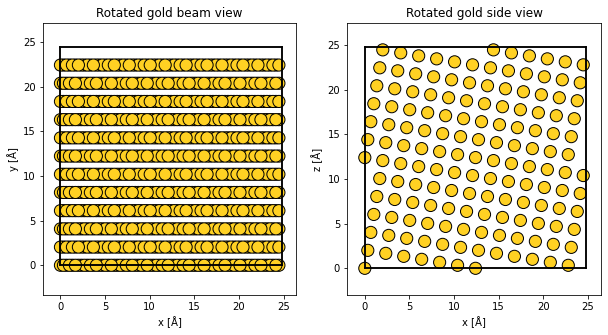

In [31]:
desired_rotation = 10

gold = build.bulk('Au', cubic=True)

gold.rotate(desired_rotation, 'y', rotate_cell=True)

gold, transform = orthogonalize_cell(gold, max_repetitions=10, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(gold * (1, 6, 1), ax=ax1, title='Rotated gold beam view')

abtem.show_atoms(gold, ax=ax2, plane='xz', title='Rotated gold side view');

As shown below, creating the rotated structure required an additional rotation of $0.538 \ \mathrm{degrees}$ around the $y$-axis. This means that within the contraint of repeating the structure at most 10 times in either direction, the closest periodic and orthogonal structure is rotated by $10.538 \ \mathrm{degrees}$ and not the desired $10.0 \ \mathrm{degrees}$. This may be close enough, if it is not `max_repetitions` may be increased. For example, within a `max_repetitions` of 20, the required transform is just $-0.008 \ \mathrm{degrees}$ around the $y$-axis.

In [32]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000
